In [1]:
%matplotlib inline
from matplotlib import pyplot

from IPython import display
from PIL import Image

import numpy as np
import os
import shutil
import time

import caffe2.python.predictor.predictor_exporter as pred_exp
import caffe2.python.predictor.predictor_py_utils as pred_utils

from caffe2.python import core, net_drawer, workspace, cnn, optimizer, brew, model_helper, visualize
from caffe2.python.predictor_constants import predictor_constants as predictor_constants




MODEL_NAME = '3-2_captcha'
TOTAL_ITERS = 20000
CLASS_NUM = 10
BIT_NUM = 4
USE_GPU = True
TB_LEN = 50

DATASET_NAME = 'final_captcha'
DATASET_FOLDER = '/home/fatesaikou/testML/machine_learning/crackCaptcha'

SAVE_MODEL = True
MODEL_SAVE_FOLDER = '/home/fatesaikou/testML/machine_learning/crackCaptcha/models'

LOAD_MODEL = True
PRETRAIN_MODEL_PATH = '/home/fatesaikou/testML/machine_learning/crackCaptcha/models/captcha_train_40000.mdl'


""" Layer Defination """

def AddInput(model, batch_size, db, db_type):
    data_uint8, label1, label2, label3, label4  = model.TensorProtosDBInput(
        [], ["data_uint8", "label1", "label2", "label3", "label4"], batch_size=batch_size,
        db=db, db_type=db_type)
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    data = model.Scale(data, data, scale=float(1./256))
    data = model.StopGradient(data, data)
    data, _ = model.Reshape(data, ['data', '_'], shape=[-1, 1, 60, 160])

    return data, [label1, label2, label3, label4]

def AddNetModel(model, data):
    conv1 = model.Conv(data, 'conv1', dim_in=1, dim_out=16, kernel=5)
    pool1 = model.MaxPool(conv1, 'pool1', kernel=2, stride=2)
    conv2 = model.Conv(pool1, 'conv2', dim_in=16, dim_out=32, kernel=5)
    pool2 = model.MaxPool(conv2, 'pool2', kernel=2, stride=2)
    
    fc3 = model.FC(pool2, 'fc3', dim_in=32 * 12 * 37, dim_out=512)
    fc3 = model.Relu(fc3, fc3)
    fc4 = model.FC(fc3, 'fc4', 512, BIT_NUM * CLASS_NUM)
    fc4s = model.DepthSplit(fc4, BIT_NUM, split=CLASS_NUM, axis=1)

    softmax = []
    softmax.append(model.Softmax(fc4s[0], 'softmax0'))
    softmax.append(model.Softmax(fc4s[1], 'softmax1'))
    softmax.append(model.Softmax(fc4s[2], 'softmax2'))
    softmax.append(model.Softmax(fc4s[3], 'softmax3'))
    
    return softmax

def AddAccuracy(model, softmax, label):
    accuracy = []
    accuracy.append(model.Accuracy([softmax[0], label[0]], "accuracy0"))
    accuracy.append(model.Accuracy([softmax[1], label[1]], "accuracy1"))
    accuracy.append(model.Accuracy([softmax[2], label[2]], "accuracy2"))
    accuracy.append(model.Accuracy([softmax[3], label[3]], "accuracy3"))

    return accuracy

def AddTrainingOperators(model, softmax, label):
    # Caculate CrossEntropy
    xents = []
    xents.append(model.LabelCrossEntropy([softmax[0], label[0]], 'xent0'))
    xents.append(model.LabelCrossEntropy([softmax[1], label[1]], 'xent1'))
    xents.append(model.LabelCrossEntropy([softmax[2], label[2]], 'xent2'))
    xents.append(model.LabelCrossEntropy([softmax[3], label[3]], 'xent3'))

    # Join Xents
    xent, _ = model.net.Concat(xents, outputs=2, axis=0)

    # Caculate Loss
    loss = model.AveragedLoss(xent, "loss")

    # Caculate Accuracy
    AddAccuracy(model, softmax, label)

    # Define Learing Rate and some other params.
    ITER = model.Iter("iter")
    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.01, policy="step", stepsize=5000, gamma=0.999)
    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
 
    # Do gradient
    gradient_map = model.AddGradientOperators([loss])
    for param in model.params:
        param_grad = gradient_map[param]
        model.WeightedSum([param, ONE, param_grad, LR], param)


""" Load/Store Model Defination """

def GetCheckpointParams(train_model):
    params = [str(p) for p in train_model.GetParams()]
    params.extend([str(p) for p in train_model.GetComputedParams()])
    assert len(params) > 0

    return params

def SaveModel(train_model, save_dir, epoch):
    predictor_export_meta = pred_exp.PredictorExportMeta(
        predict_net=train_model.net.Proto(),
        parameters=GetCheckpointParams(train_model),
        inputs=['data_uint8'],
        outputs=['softmax'],
        shapes={
            'data': {1, 9600},
            'softmax': {1, 40}
        }
    )
    
    model_path = '%s/%s_%d.mdl' % (
        save_dir,
        train_model.net.Proto().name,
        epoch,
    )

    pred_exp.save_to_db(
        db_type='minidb',
        db_destination=model_path,
        predictor_export_meta=predictor_export_meta,
    )

def LoadModel(path):
    meta_net_def = pred_exp.load_from_db(path, 'minidb')
    init_net = core.Net(pred_utils.GetNet(
        meta_net_def, predictor_constants.GLOBAL_INIT_NET_TYPE))
    predict_init_net = core.Net(pred_utils.GetNet(
        meta_net_def, predictor_constants.PREDICT_INIT_NET_TYPE))
    
    predict_init_net.RunAllOnGPU()
    init_net.RunAllOnGPU()

    assert workspace.RunNetOnce(predict_init_net)
    assert workspace.RunNetOnce(init_net)


""" Display Utils """

def GetTimeRemain(i, total_i, start):
    passed = time.time() - start
    remain_time = passed * (total_i - i) / i

    return '%d:%02d' % (int(remain_time / 60), remain_time % 60)


In [2]:
""" Defination of Train Model """

train_model = cnn.CNNModelHelper(
    order="NCHW",
    name=MODEL_NAME + "_train",
    init_params=not LOAD_MODEL
)
data, label = AddInput(
    train_model, batch_size=10,
    db=os.path.join(DATASET_FOLDER, DATASET_NAME + '_train.minidb'),
    db_type='minidb'
)
softmax = AddNetModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)

""" Defination of Test Model """

test_model = cnn.CNNModelHelper(
    order="NCHW",
    name=MODEL_NAME + "_test",
    init_params=False
)
data, label = AddInput(
    test_model, batch_size=1000,
    db=os.path.join(DATASET_FOLDER, DATASET_NAME + '_test.minidb'),
    db_type='minidb'
)
softmax = AddNetModel(test_model, data)
AddAccuracy(test_model, softmax, label)

[None, None, None, None]

In [3]:
""" Net Initialization """

workspace.ResetWorkspace()

if USE_GPU:
    train_model.param_init_net.RunAllOnGPU()
    train_model.net.RunAllOnGPU()
    test_model.param_init_net.RunAllOnGPU()
    test_model.net.RunAllOnGPU()

if LOAD_MODEL:
    LoadModel(PRETRAIN_MODEL_PATH)
    
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net)


""" Training Initialization"""

start_time = time.time()
loss = []
train_accuracys = [[], [], [], []]
val_accuracy = []

In [4]:
""" Training """

for i in range(1, TOTAL_ITERS + 1):
    # Training Phase
    workspace.RunNet(train_model.net.Proto().name)
   
    train_a1 = workspace.FetchBlob('accuracy0')
    train_a2 = workspace.FetchBlob('accuracy1')
    train_a3 = workspace.FetchBlob('accuracy2')
    train_a4 = workspace.FetchBlob('accuracy3')
    
    train_loss = workspace.FetchBlob('loss')

    if i % 100 == 0:
        os.system('clear')
        train_accuracys[0].append(train_a1)
        train_accuracys[1].append(train_a2)
        train_accuracys[2].append(train_a3)
        train_accuracys[3].append(train_a4)
        loss.append(train_loss)
        
        print ' TimeRemain <', GetTimeRemain(i, TOTAL_ITERS, start_time), '>'
        print ' ----> [' + ('=' * int(i * TB_LEN / TOTAL_ITERS) + '>').ljust(TB_LEN) + '] <----'
        print ' - Iter -', i, '/', TOTAL_ITERS
        print ' - Loss - ', train_loss
        print ' - Label1AC: ', train_a1
        print ' - Label2AC: ', train_a2
        print ' - Label3AC: ', train_a3
        print ' - Label4AC: ', train_a4
        
    
    # Val Phase
    if i % 200 == 0:
        workspace.RunNet(test_model.net.Proto().name)

        a1 = ([s.argmax() for s in workspace.FetchBlob('softmax0')] - workspace.FetchBlob('label1'))
        a2 = ([s.argmax() for s in workspace.FetchBlob('softmax1')] - workspace.FetchBlob('label2'))
        a3 = ([s.argmax() for s in workspace.FetchBlob('softmax2')] - workspace.FetchBlob('label3'))
        a4 = ([s.argmax() for s in workspace.FetchBlob('softmax3')] - workspace.FetchBlob('label4'))
        correct_num = 1000 - np.count_nonzero(a1 | a2 | a3 | a4)
    
        val_accuracy.append(correct_num / 1000.0)
        print ' - Test AC - %f' % (correct_num / 1000.0)

        if SAVE_MODEL:
            SaveModel(train_model, MODEL_SAVE_FOLDER, i)


 TimeRemain < 15:56 >
 ----> [>                                                 ] <----
 - Iter - 100 / 20000
 - Loss -  0.00453926017508
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 9:46 >
 ----> [>                                                 ] <----
 - Iter - 200 / 20000
 - Loss -  0.00344210164621
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.937000
 TimeRemain < 7:58 >
 ----> [>                                                 ] <----
 - Iter - 300 / 20000
 - Loss -  0.00470908079296
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 6:51 >
 ----> [=>                                                ] <----
 - Iter - 400 / 20000
 - Loss -  0.036461699754
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  0.899999976158
 - Test AC - 0.948000
 TimeRemain < 6:16 >
 ----> [=>                                                ] <----
 - Iter - 500 / 20000
 

 TimeRemain < 3:35 >
 ----> [=========>                                        ] <----
 - Iter - 3800 / 20000
 - Loss -  0.0610582008958
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  0.899999976158
 - Test AC - 0.941000
 TimeRemain < 3:33 >
 ----> [=========>                                        ] <----
 - Iter - 3900 / 20000
 - Loss -  0.0125952158123
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 3:31 >
 ----> [==========>                                       ] <----
 - Iter - 4000 / 20000
 - Loss -  0.107046879828
 - Label1AC:  1.0
 - Label2AC:  0.899999976158
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.948000
 TimeRemain < 3:29 >
 ----> [==========>                                       ] <----
 - Iter - 4100 / 20000
 - Loss -  0.00552895246074
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 3:27 >
 ----> [==========>                                       ] <----
 - Iter - 4

 TimeRemain < 2:41 >
 ----> [==================>                               ] <----
 - Iter - 7500 / 20000
 - Loss -  0.00042870483594
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 2:40 >
 ----> [===================>                              ] <----
 - Iter - 7600 / 20000
 - Loss -  0.00394361978397
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.945000
 TimeRemain < 2:38 >
 ----> [===================>                              ] <----
 - Iter - 7700 / 20000
 - Loss -  0.0183165296912
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 2:37 >
 ----> [===================>                              ] <----
 - Iter - 7800 / 20000
 - Loss -  0.00985600613058
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.947000
 TimeRemain < 2:36 >
 ----> [===================>                              ] <----
 - Iter - 7900 / 20000
 - Loss

 TimeRemain < 1:52 >
 ----> [============================>                     ] <----
 - Iter - 11200 / 20000
 - Loss -  0.00382871367037
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.942000
 TimeRemain < 1:51 >
 ----> [============================>                     ] <----
 - Iter - 11300 / 20000
 - Loss -  0.000787750177551
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 1:49 >
 ----> [============================>                     ] <----
 - Iter - 11400 / 20000
 - Loss -  0.000708659936208
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.954000
 TimeRemain < 1:48 >
 ----> [============================>                     ] <----
 - Iter - 11500 / 20000
 - Loss -  0.00153989740647
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 1:47 >
 ----> [=============================>                    ] <----
 - Iter - 11600 / 20000

 TimeRemain < 1:04 >
 ----> [=====================================>            ] <----
 - Iter - 14900 / 20000
 - Loss -  0.00721045583487
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 1:02 >
 ----> [=====================================>            ] <----
 - Iter - 15000 / 20000
 - Loss -  0.0155853694305
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.952000
 TimeRemain < 1:01 >
 ----> [=====================================>            ] <----
 - Iter - 15100 / 20000
 - Loss -  0.013857409358
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 1:00 >
 ----> [======================================>           ] <----
 - Iter - 15200 / 20000
 - Loss -  0.00221049413085
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.948000
 TimeRemain < 0:59 >
 ----> [======================================>           ] <----
 - Iter - 15300 / 20000
 - L

 TimeRemain < 0:17 >
 ----> [==============================================>   ] <----
 - Iter - 18600 / 20000
 - Loss -  0.00266844592988
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.958000
 TimeRemain < 0:16 >
 ----> [==============================================>   ] <----
 - Iter - 18700 / 20000
 - Loss -  0.00206207088195
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 0:14 >
 ----> [===============================================>  ] <----
 - Iter - 18800 / 20000
 - Loss -  0.000532199104782
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 - Test AC - 0.946000
 TimeRemain < 0:13 >
 ----> [===============================================>  ] <----
 - Iter - 18900 / 20000
 - Loss -  0.00127703126054
 - Label1AC:  1.0
 - Label2AC:  1.0
 - Label3AC:  1.0
 - Label4AC:  1.0
 TimeRemain < 0:12 >
 ----> [===============================================>  ] <----
 - Iter - 19000 / 20000


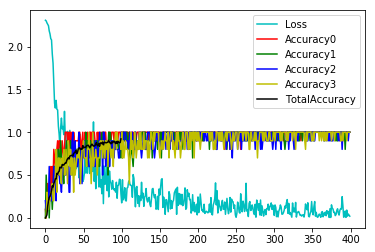

In [5]:
# After the execution is done, let's plot the values.
pyplot.plot(loss, 'c')
pyplot.plot(train_accuracys[0], 'r')
pyplot.plot(train_accuracys[1], 'g')
pyplot.plot(train_accuracys[2], 'b')
pyplot.plot(train_accuracys[3], 'y')
pyplot.plot(val_accuracy, 'k')
pyplot.legend(('Loss', 'Accuracy0', 'Accuracy1', 'Accuracy2', 'Accuracy3', 'TotalAccuracy'), loc='upper right')

In [7]:
""" Testing """

test_accuracy = []
accuracys = [[]] * 4
for i in range(100):
    workspace.RunNet(test_model.net.Proto().name)

    a1 = ([s.argmax() for s in workspace.FetchBlob('softmax0')] - workspace.FetchBlob('label1'))
    a2 = ([s.argmax() for s in workspace.FetchBlob('softmax1')] - workspace.FetchBlob('label2'))
    a3 = ([s.argmax() for s in workspace.FetchBlob('softmax2')] - workspace.FetchBlob('label3'))
    a4 = ([s.argmax() for s in workspace.FetchBlob('softmax3')] - workspace.FetchBlob('label4'))
    correct_num = 1000 - np.count_nonzero(a1 | a2 | a3 | a4)
   
    acc_str = 'Test %d: ' % i
    for j, item in enumerate([a1, a2, a3, a4]):
        acc_str = acc_str + 'label%d-acc: %f, ' % (j, (1000 - np.count_nonzero(item)) / 1000.0)
        accuracys[j] = accuracys[j][:] + [(1000 - np.count_nonzero(item)) / 1000.0]
        
    print acc_str
        
        
    test_accuracy.append(correct_num / 1000.0)

print('accuracy 1: %f' % np.mean(accuracys[0]))
print('accuracy 2: %f' % np.mean(accuracys[1]))
print('accuracy 3: %f' % np.mean(accuracys[2]))
print('accuracy 4: %f' % np.mean(accuracys[3]))
print('test_accuracy: %f' % np.mean(test_accuracy))

Test 0: label0-acc: 0.992000, label1-acc: 0.978000, label2-acc: 0.946000, label3-acc: 0.946000, 
Test 1: label0-acc: 0.985000, label1-acc: 0.981000, label2-acc: 0.946000, label3-acc: 0.949000, 
Test 2: label0-acc: 0.992000, label1-acc: 0.978000, label2-acc: 0.954000, label3-acc: 0.956000, 
Test 3: label0-acc: 0.989000, label1-acc: 0.976000, label2-acc: 0.956000, label3-acc: 0.953000, 
Test 4: label0-acc: 0.989000, label1-acc: 0.973000, label2-acc: 0.955000, label3-acc: 0.965000, 
Test 5: label0-acc: 0.990000, label1-acc: 0.972000, label2-acc: 0.952000, label3-acc: 0.949000, 
Test 6: label0-acc: 0.992000, label1-acc: 0.975000, label2-acc: 0.955000, label3-acc: 0.952000, 
Test 7: label0-acc: 0.988000, label1-acc: 0.977000, label2-acc: 0.950000, label3-acc: 0.958000, 
Test 8: label0-acc: 0.986000, label1-acc: 0.963000, label2-acc: 0.958000, label3-acc: 0.959000, 
Test 9: label0-acc: 0.993000, label1-acc: 0.983000, label2-acc: 0.959000, label3-acc: 0.957000, 
Test 10: label0-acc: 0.993000,

Test 84: label0-acc: 0.990000, label1-acc: 0.982000, label2-acc: 0.961000, label3-acc: 0.963000, 
Test 85: label0-acc: 0.990000, label1-acc: 0.971000, label2-acc: 0.960000, label3-acc: 0.958000, 
Test 86: label0-acc: 0.982000, label1-acc: 0.971000, label2-acc: 0.945000, label3-acc: 0.956000, 
Test 87: label0-acc: 0.993000, label1-acc: 0.977000, label2-acc: 0.952000, label3-acc: 0.961000, 
Test 88: label0-acc: 0.986000, label1-acc: 0.969000, label2-acc: 0.960000, label3-acc: 0.961000, 
Test 89: label0-acc: 0.990000, label1-acc: 0.976000, label2-acc: 0.946000, label3-acc: 0.958000, 
Test 90: label0-acc: 0.989000, label1-acc: 0.972000, label2-acc: 0.962000, label3-acc: 0.964000, 
Test 91: label0-acc: 0.991000, label1-acc: 0.978000, label2-acc: 0.947000, label3-acc: 0.960000, 
Test 92: label0-acc: 0.987000, label1-acc: 0.977000, label2-acc: 0.954000, label3-acc: 0.957000, 
Test 93: label0-acc: 0.991000, label1-acc: 0.972000, label2-acc: 0.952000, label3-acc: 0.952000, 
Test 94: label0-acc:

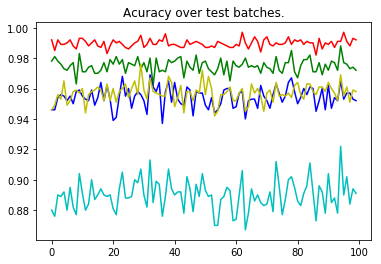

In [8]:
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'c')
pyplot.plot(accuracys[0], 'r')
pyplot.plot(accuracys[1], 'g')
pyplot.plot(accuracys[2], 'b')
pyplot.plot(accuracys[3], 'y')
pyplot.title('Acuracy over test batches.')

<<<Ori Data>>>


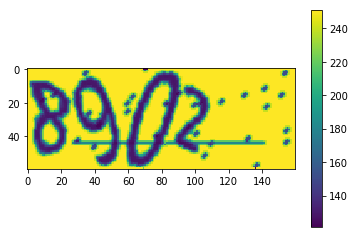

In [9]:
pyplot.imshow(workspace.FetchBlob('data_uint8')[4].reshape(60, 160))
pyplot.colorbar()
print '<<<Ori Data>>>'

<<<Conv1>>>


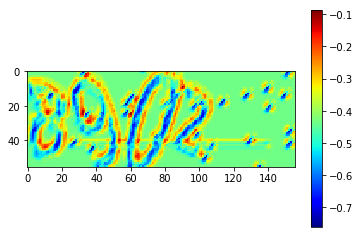

In [10]:
conv1_filters = workspace.FetchBlob('conv1')[4]
conv1_filters = conv1_filters / np.linalg.norm(conv1_filters, axis=0)
pyplot.imshow(conv1_filters.sum(axis=0), cmap=pyplot.cm.jet)
pyplot.colorbar()
print '<<<Conv1>>>'

<<<Pool1>>>


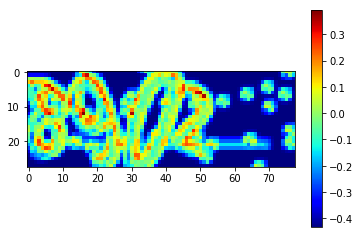

In [11]:
pool1_filters = workspace.FetchBlob('pool1')[4]
pool1_filters = pool1_filters / np.linalg.norm(pool1_filters, axis=0)
pyplot.imshow(pool1_filters.sum(axis=0), cmap=pyplot.cm.jet)
pyplot.colorbar()
print '<<<Pool1>>>'

<<<Conv2>>>


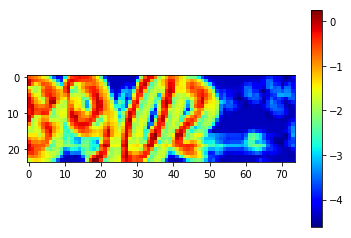

In [12]:
conv2_filters = workspace.FetchBlob('conv2')[4]
conv2_filters = conv2_filters / np.linalg.norm(conv2_filters, axis=0)
pyplot.imshow(conv2_filters.sum(axis=0), cmap=pyplot.cm.jet)
pyplot.colorbar()
print '<<<Conv2>>>'

<<<Pool2>>>


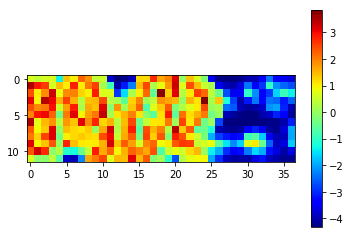

In [13]:
pool2_filters = workspace.FetchBlob('pool2')[4]
pool2_filters = pool2_filters / np.linalg.norm(pool2_filters, axis=0)
pyplot.imshow(pool2_filters.sum(axis=0), cmap=pyplot.cm.jet)
pyplot.colorbar()
print '<<<Pool2>>>'

[ 80  94  14 117  61]
[227 229 219 165 149]
[382 288 334 265 335]
[445 461 473 423 483]


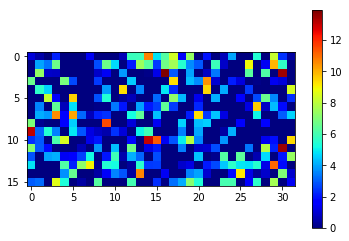

In [14]:
fc3_data = workspace.FetchBlob('fc3')[4]
pyplot.imshow(fc3_data.reshape(16, 32), cmap=pyplot.cm.jet)
pyplot.colorbar()
print fc3_data[:128].argsort()[-5:][::-1]
print fc3_data[128:256].argsort()[-5:][::-1] + 128
print fc3_data[256:384].argsort()[-5:][::-1] + 256
print fc3_data[384:512].argsort()[-5:][::-1] + 384

[3 7 0 1 9]
[14 17 19 16 13]
[29 27 24 21 23]
[35 33 34 30 31]


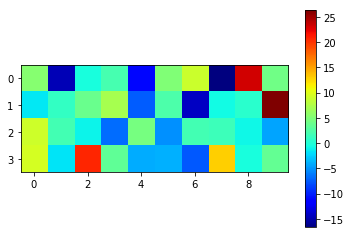

In [15]:
fc4_data = workspace.FetchBlob('fc4')[4]
pyplot.imshow(fc4_data.reshape(4, 10), cmap=pyplot.cm.jet)
pyplot.colorbar()
print fc3_data[:10].argsort()[-5:][::-1]
print fc3_data[10:20].argsort()[-5:][::-1] + 10
print fc3_data[20:30].argsort()[-5:][::-1] + 20
print fc3_data[30:40].argsort()[-5:][::-1] + 30

In [16]:
softmax0 = workspace.FetchBlob('softmax0')[4]
softmax1 = workspace.FetchBlob('softmax1')[4]
softmax2 = workspace.FetchBlob('softmax2')[4]
softmax3 = workspace.FetchBlob('softmax3')[4]

print softmax0.argmax(), softmax1.argmax(), softmax2.argmax(), softmax3.argmax()

8 9 0 2


In [54]:
def FindIndexes(labels, aim):    
    return np.squeeze(np.argwhere(labels == aim))

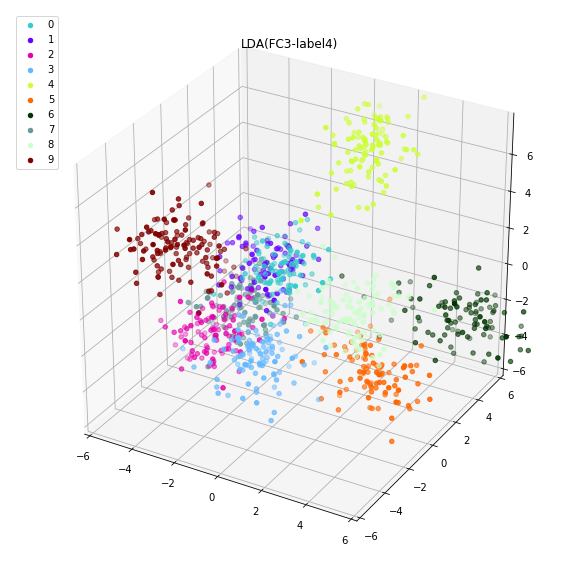

In [75]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.lda import LDA

def display_mnist_3d(data, n_samples):
    X, y = data[0] / 255.0, data[1]

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_train, y_train = X[indices[:n_samples]], y[indices[:n_samples]]

    X_lda = LDA(n_components=3).fit_transform(X_train, y_train)


    fig, ax = pyplot.subplots(figsize=(10,10), subplot_kw={'projection':'3d'})

    
    colors = ['#33cccc', "#6600ff", '#e600ac', '#63B8FF', "#ccff33", '#ff6600', '#003300', '#669999', '#ccffcc', '#800000']
    for i in xrange(10):
        indexes = FindIndexes(y_train, i)
        points = ax.scatter(X_lda[indexes, 0], X_lda[indexes, 1], X_lda[indexes, 2], c=colors[i], label=i)
    
    ax.set_title('LDA(FC3-label4)')
    ax.set_xlim((-6, 6))
    ax.set_ylim((-6, 6))
    ax.legend(loc = 'upper left')

    pyplot.show(fig)


display_mnist_3d([workspace.FetchBlob('fc3'), workspace.FetchBlob('label4')], 1000)

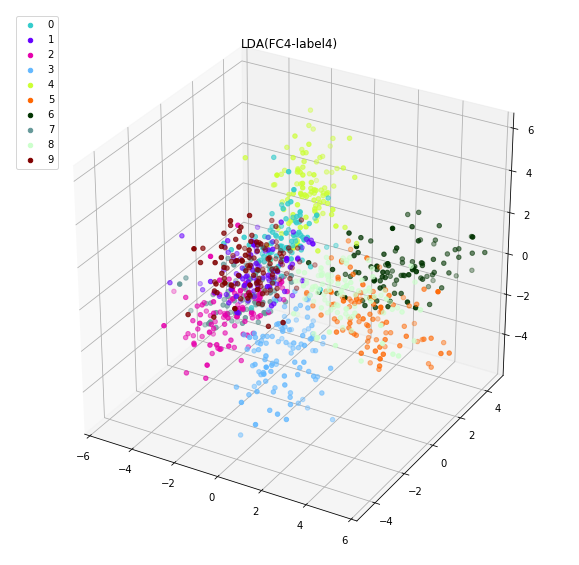

In [79]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.lda import LDA

def display_mnist_3d(data, n_samples):
    X, y = data[0] / 255.0, data[1]

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_train, y_train = X[indices[:n_samples]], y[indices[:n_samples]]

    X_lda = LDA(n_components=3).fit_transform(X_train, y_train)


    fig, ax = pyplot.subplots(figsize=(10,10), subplot_kw={'projection':'3d'})

    
    colors = ['#33cccc', "#6600ff", '#e600ac', '#63B8FF', "#ccff33", '#ff6600', '#003300', '#669999', '#ccffcc', '#800000']
    for i in xrange(10):
        indexes = FindIndexes(y_train, i)
        points = ax.scatter(X_lda[indexes, 0], X_lda[indexes, 1], X_lda[indexes, 2], c=colors[i], label=i)
    
    ax.set_title('LDA(FC4-label4)')
    ax.set_xlim((-6, 6))
    ax.set_ylim((-5, 5))
    ax.legend(loc = 'upper left')

    pyplot.show(fig)


display_mnist_3d([workspace.FetchBlob('fc4'), workspace.FetchBlob('label4')], 1000)